Import libraries and dataset



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = pd.read_csv('/content/ridelink_data.csv')

X_user1 = df[['user1_distance_from_school', 'user1_flexibility_distance',
               'user1_flexibility_time', 'user1_school_start_time',
               'user1_leave_time']].values

X_user2 = df[['user2_distance_from_school', 'user2_flexibility_distance',
               'user2_flexibility_time', 'user2_school_start_time',
               'user2_leave_time']].values

X_distance = df['distance_between_users'].values.reshape(-1, 1)

y = df['similarity_score'].values.reshape(-1, 1)

Display first 10 values of dataset

In [ ]:
print(df.head(10).to_string(index=False))

 user1_distance_from_school  user2_distance_from_school  user1_flexibility_distance  user2_flexibility_distance  user1_flexibility_time  user2_flexibility_time  user1_school_start_time  user2_school_start_time  user1_leave_time  user2_leave_time  distance_between_users  similarity_score
                   1.766329                    1.978186                    7.550290                    6.644697                2.843821                7.735227                 8.364764                 7.212882          6.625128          7.907621                1.160288          0.538984
                   0.509303                    1.030914                    4.630191                    2.064690                8.557323                9.362802                 8.637906                 8.261875          6.647073          8.366732                1.967037          0.393407
                   2.027315                    0.857152                    5.264049                    4.600399                1.584418 

Normalize the data

In [ ]:
scaler_user1 = StandardScaler()
scaler_user2 = StandardScaler()
scaler_distance = StandardScaler()

X_user1_scaled = scaler_user1.fit_transform(X_user1)
X_user2_scaled = scaler_user2.fit_transform(X_user2)
X_distance_scaled = scaler_distance.fit_transform(X_distance)

Create architecture of neural collaborative filtering model.

In [ ]:
lambda_regularization = 0.001

def create_ncf_model():
    user1_input = layers.Input(shape=(5,), name='User1_Input')
    user2_input = layers.Input(shape=(5,), name='User2_Input')
    distance_input = layers.Input(shape=(1,), name='Distance_Input')

    user1_embedding = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(lambda_regularization))(user1_input)
    user2_embedding = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(lambda_regularization))(user2_input)

    concatenated = layers.Concatenate()([user1_embedding, user2_embedding, distance_input])

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(lambda_regularization))(concatenated)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(lambda_regularization))(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(lambda_regularization))(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[user1_input, user2_input, distance_input], outputs=output)
    return model

model = create_ncf_model()

Display the architecture to view

In [ ]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User1_Input (InputLayer)  │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User2_Input (InputLayer)  │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_60 (Dense)          │ (None, 64)             │            384 │ User1_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_61 (Dense)          │ (None, 64)             │            384 │ User2_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Distance_Input            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 129)            │              0 │ dense_60[0][0],        │
│ (Concatenate)             │                        │                │ dense_61[0][0],        │
│                           │                        │                │ Distance_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_62 (Dense)          │ (None, 128)            │         16,640 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_63 (Dense)          │ (None, 64)             │          8,256 │ dense_62[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_64 (Dense)          │ (None, 32)             │          2,080 │ dense_63[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_65 (Dense)          │ (None, 1)              │             33 │ dense_64[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,777 (108.50 KB)

 Trainable params: 27,777 (108.50 KB)

 Non-trainable params: 0 (0.00 B)

Train the model to fit to the training data

In [ ]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

history = model.fit(
    [X_user1_scaled, X_user2_scaled, X_distance_scaled],
    y,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 0.2504 - mae: 0.1236 - val_loss: 0.1078 - val_mae: 0.0483
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0871 - mae: 0.0449 - val_loss: 0.0417 - val_mae: 0.0464
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0361 - mae: 0.0422 - val_loss: 0.0243 - val_mae: 0.0419
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0221 - mae: 0.0388 - val_loss: 0.0162 - val_mae: 0.0405
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - mae: 0.0386 - val_loss: 0.0114 - val_mae: 0.0399
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - mae: 0.0428 - val_loss: 0.0090 - val_mae: 0.0386
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - mae: 0.0436 - val_loss: 0.0088 - val_mae: 0.0470
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mae: 0.0419 - val_loss: 0.0081 - val_mae: 0.0463
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - mae: 0.0459 

Display plots
- Training and Validation Loss
- Original vs Predicted Scores

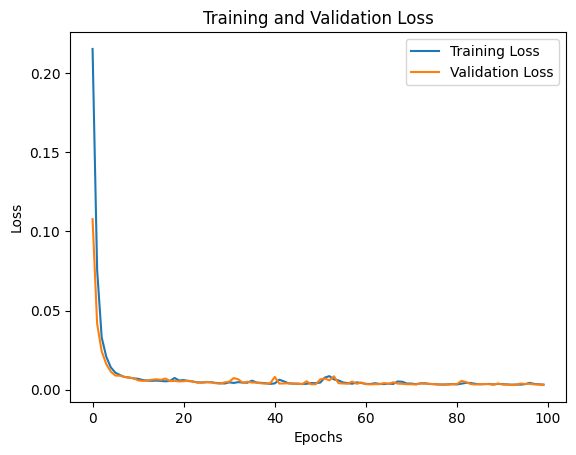

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
similarity_scores = model.predict([X_user1_scaled, X_user2_scaled, X_distance_scaled])
print("Similarity scores:\n", similarity_scores[:5])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Similarity scores:
 [[0.6110906 ]
 [0.405111  ]
 [0.24378403]
 [0.58886194]
 [0.50819415]]


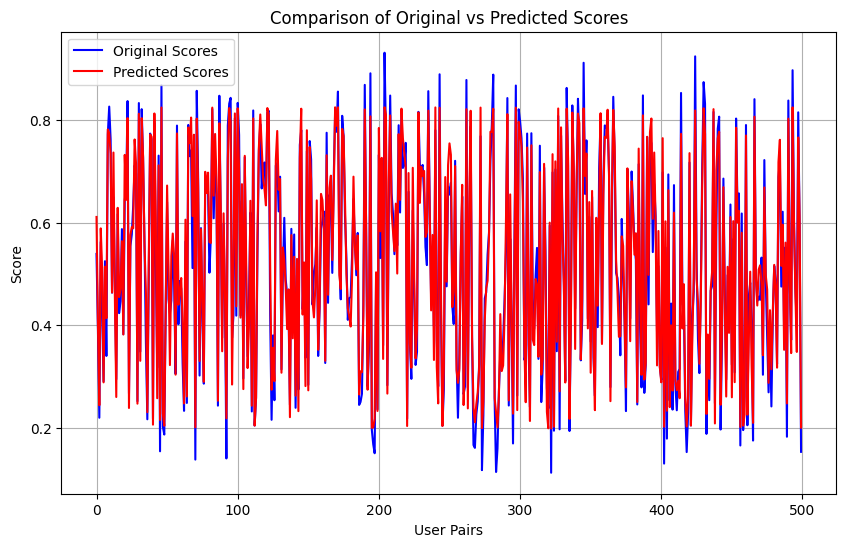

In [ ]:
x = np.arange(len(y))

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Original Scores', color='b')
plt.plot(x, similarity_scores, label='Predicted Scores', color='r')

plt.title('Comparison of Original vs Predicted Scores')
plt.xlabel('User Pairs')
plt.ylabel('Score')
plt.legend()

plt.grid(True)
plt.show()

Save and downlaod model to load to API

In [ ]:
model.save('ridelink_model.keras')

In [ ]:
from google.colab import files
files.download('ridelink_model.keras')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download model scalers to load to API

In [ ]:
import joblib

joblib.dump(scaler_user1, 'scaler_user1.joblib')
joblib.dump(scaler_user2, 'scaler_user2.joblib')
joblib.dump(scaler_distance, 'scaler_distance.joblib')

['scaler_distance.joblib']

In [ ]:
files.download('scaler_user1.joblib')
files.download('scaler_user2.joblib')
files.download('scaler_distance.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>